In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np 
import os
import pickle

In [2]:
data = pd.read_csv('./bluerock_data.csv')

In [23]:
df = data
df['datetime'] = pd.to_datetime(df['TimeStamp'], format= '%Y-%m-%dT%H:%M:%S')
df['datetime'] = df['datetime'].apply(lambda t: t.replace(tzinfo=None))
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

In [24]:
df = df[~df.index.duplicated(keep='first')]
df = df.drop('Location', axis=1)
features = ['PT4', 'FT0', 'PT2', 'PT3',
            'PT5', 'PF', 'FT1', 'FT2', 'CT1', 
            'CT2', 'NT1', 'SP', 'state']
currFeaturesNames = ['PT4-HP Concentrate (psig)', 'FTF-Raw Feed Inflow (gpm)',
             'PT2-RO Pump Inlet(psig)', 'PT3-RO Pump Outlet (psig)', 'PT5-Permeate (psig)', 'Permeate Flux (gfd)', 'FT1-Inlet (gpm)',
             'FT2-Recycle (gpm)', 'CT1-Feed (uS)', 'CT2-Permeate (uS)', 'NT1-Permeate (ppm NO3-N)',
             'Salt Passage (%)', 'RO State']

df = df[currFeaturesNames]
df.columns = features
df = df.dropna(axis=0)
df.head()

,PT4,FT0,PT2,PT3,PT5,PF,FT1,FT2,CT1,CT2,NT1,SP,state
datetime,,,,,,,,,,,,,
2020-07-02 23:57:37.334,127.8031,2.439792,81.86849,134.8560,3.602431,15.192457,7.065172,4.625380,2237.413,69.44445,3.354734,3.103783,2
2020-07-02 23:58:07.330,123.9330,1.761641,82.06380,129.0328,3.613281,9.870031,4.829919,3.068278,2259.115,68.46789,3.440637,3.030739,2
2020-07-02 23:58:37.394,122.1969,1.889197,82.16146,127.1159,3.634983,10.922552,5.264347,3.375150,2295.283,68.97425,3.490370,3.005043,2
2020-07-02 23:59:07.934,123.4990,1.969251,82.04211,129.0509,3.613281,11.637843,5.652052,3.682801,2307.581,70.74653,3.485849,3.065831,2
2020-07-02 23:59:37.724,122.8118,2.041585,82.11806,128.3095,3.613281,12.329805,5.851588,3.810003,2281.178,71.18055,3.531061,3.120342,2


In [26]:
df = df.loc[df.state.isin([2, 3, 4, 5])]
aggreg_dict = {}
for col in df.columns:
    if col != 'state':
        aggreg_dict[col] = 'mean'
    else:
        aggreg_dict[col] = 'last'
        
df = df.resample('5s').agg(aggreg_dict)
df[[col for col in df.columns if col != 'state']].interpolate(method='linear', inplace=True)
df['state'].interpolate(method='ffill', inplace=True)


for col in df.columns:
    if col == 'SP':
        df.SP = df.SP.mask(df.SP >= 100).ffill(downcast='infer')
    elif col != 'state':
        df[col] = df[col].mask(df[col] <= 0).ffill(downcast='infer')
    


In [27]:
state_values = df.state.values
first_indices = [ix for ix in range(len(df.index.values)-1) if state_values[ix] != 2 and state_values[ix+1] == 2]
for first_ix in first_indices:
    state_values[first_ix:first_ix+1000] = -2 # startup
    
last_indices = [ix for ix in range(len(df.index.values)-1) if state_values[ix] == 2 and state_values[ix+1] != 2]
for last_ix in last_indices:
    state_values[last_ix-1000:last_ix] = -1 # shutdown
    
df.state = state_values
    

In [28]:
df = df.truncate(after=df.index[len(df.index.values)-2000000]) # has missing values

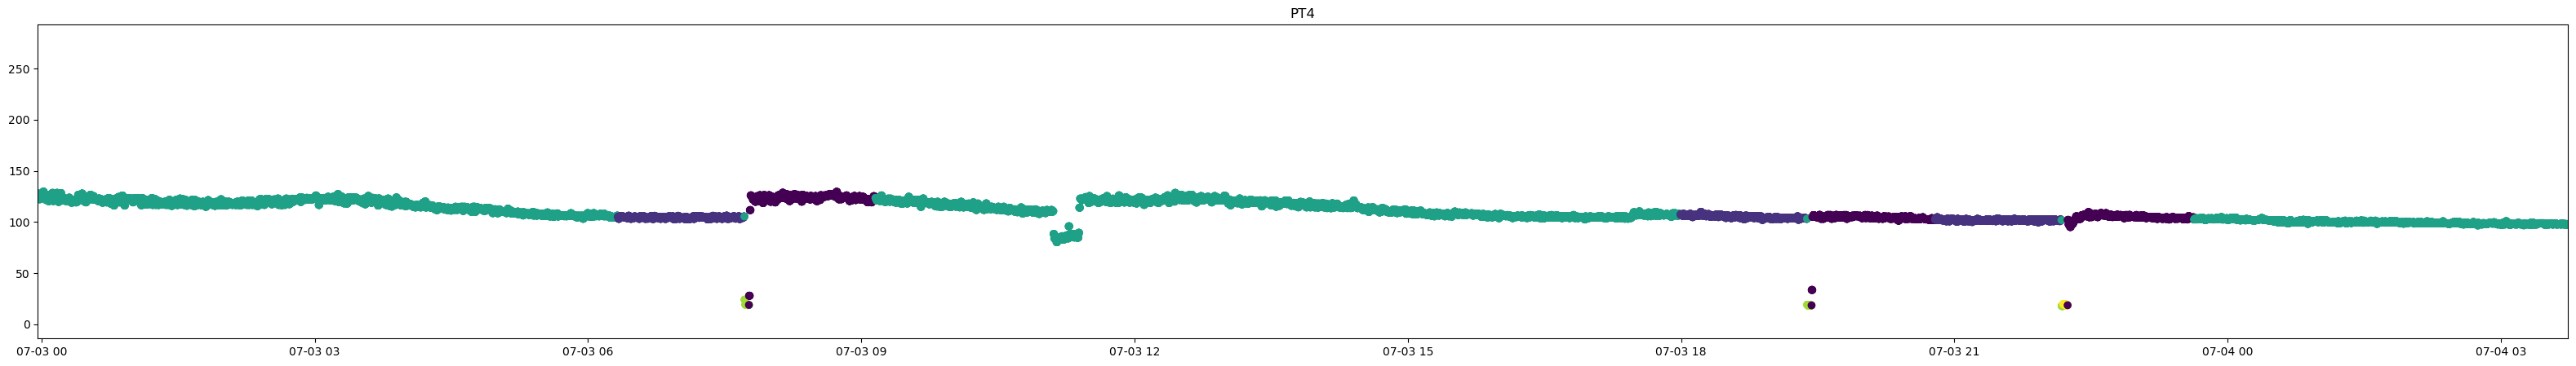

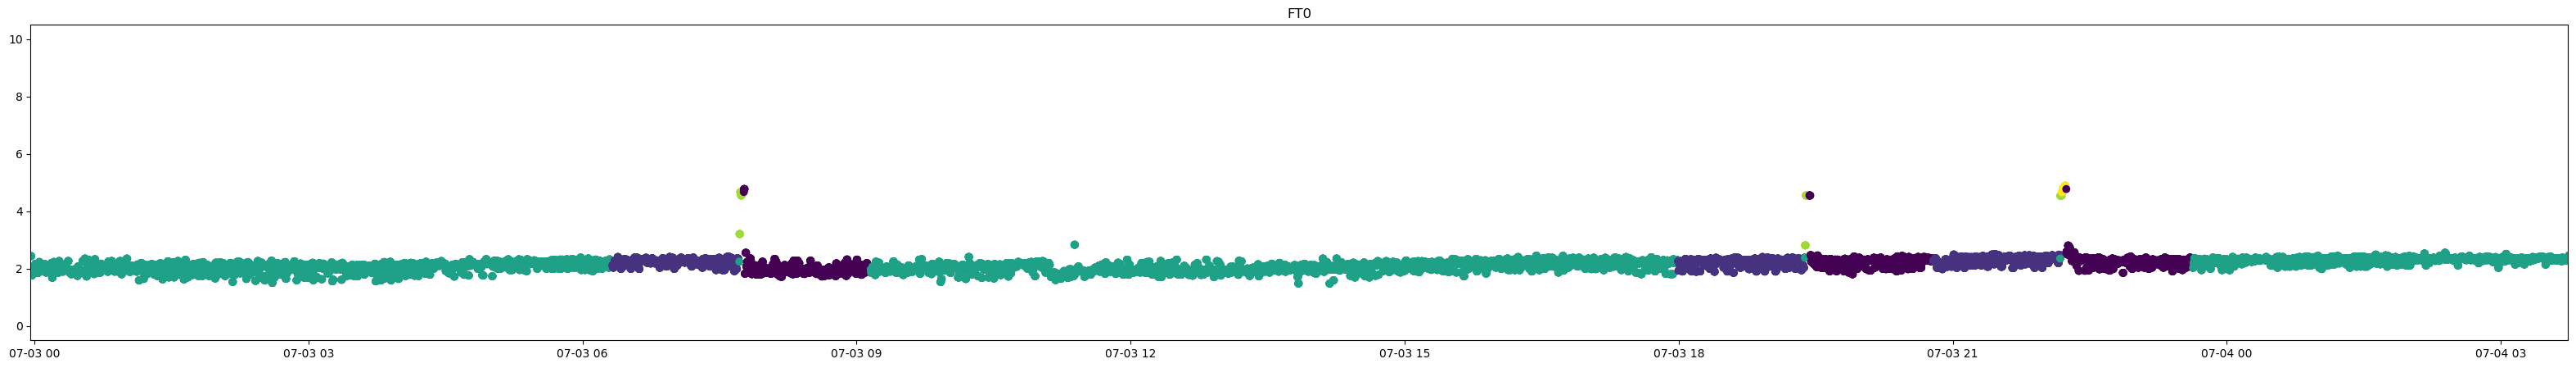

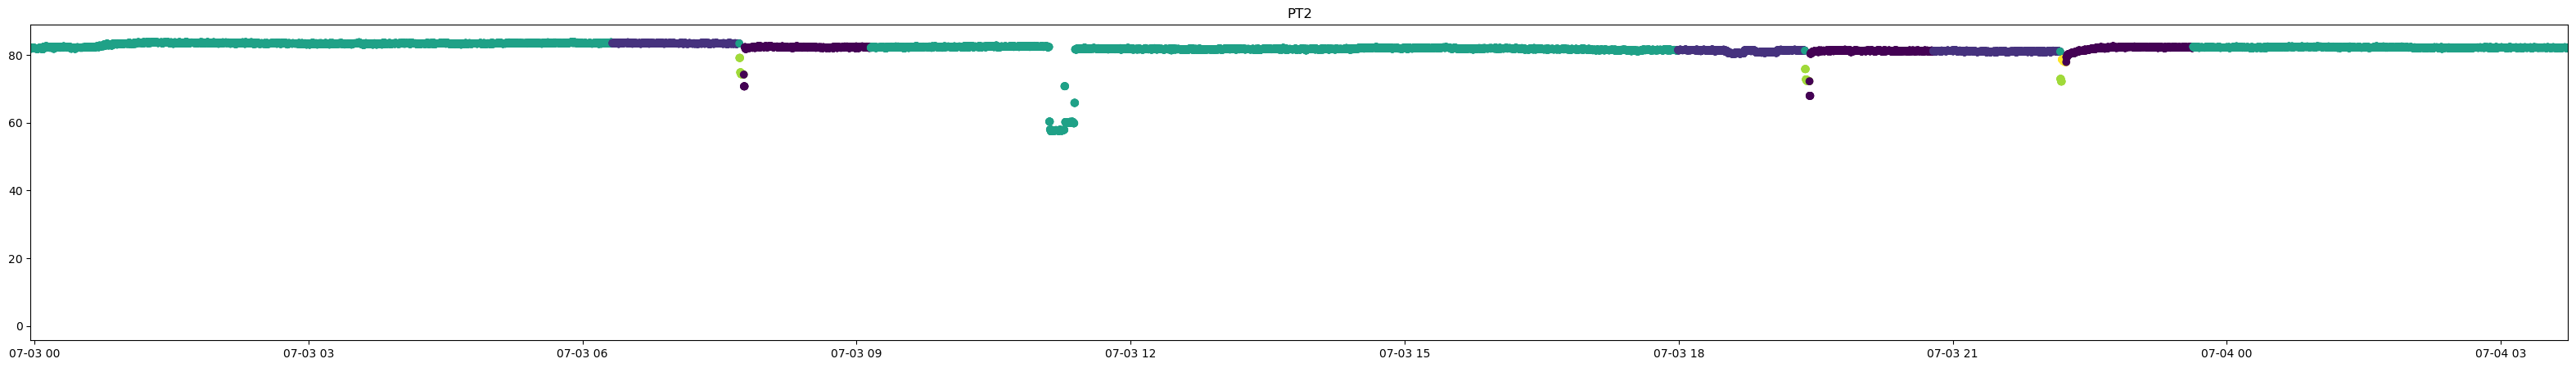

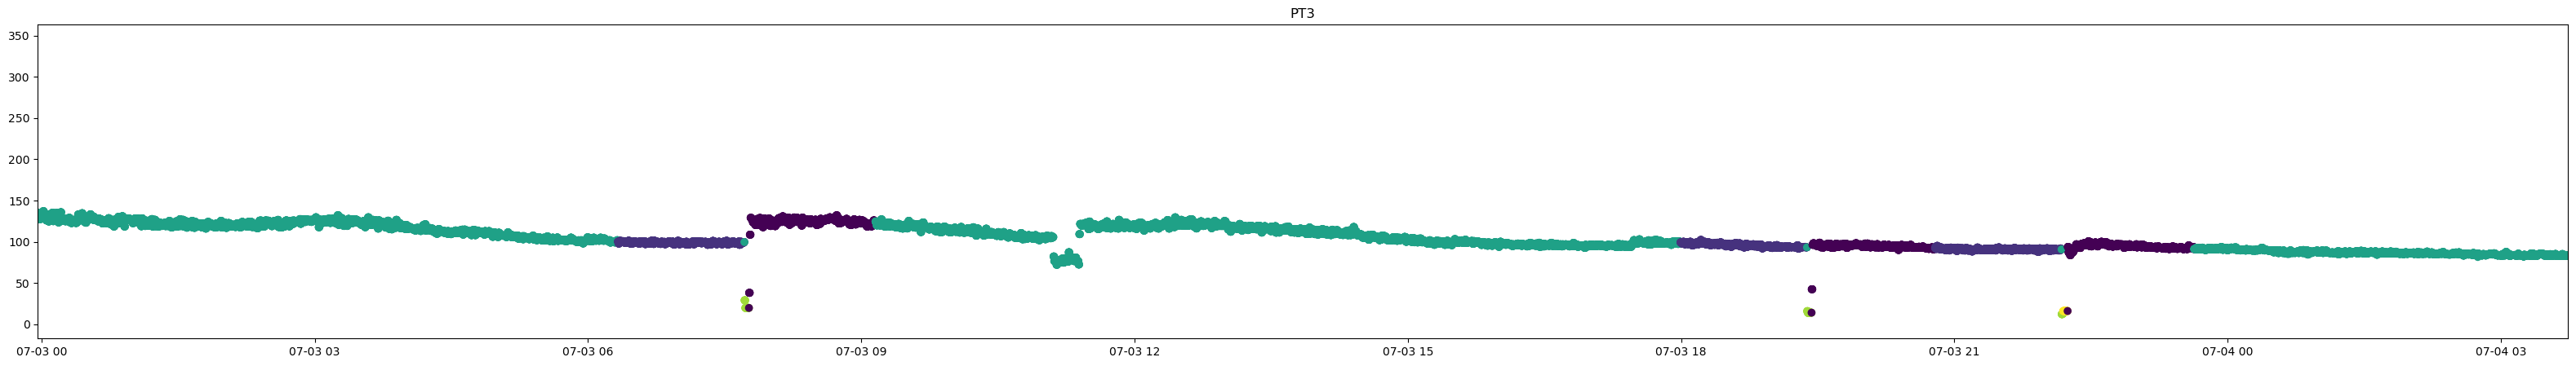

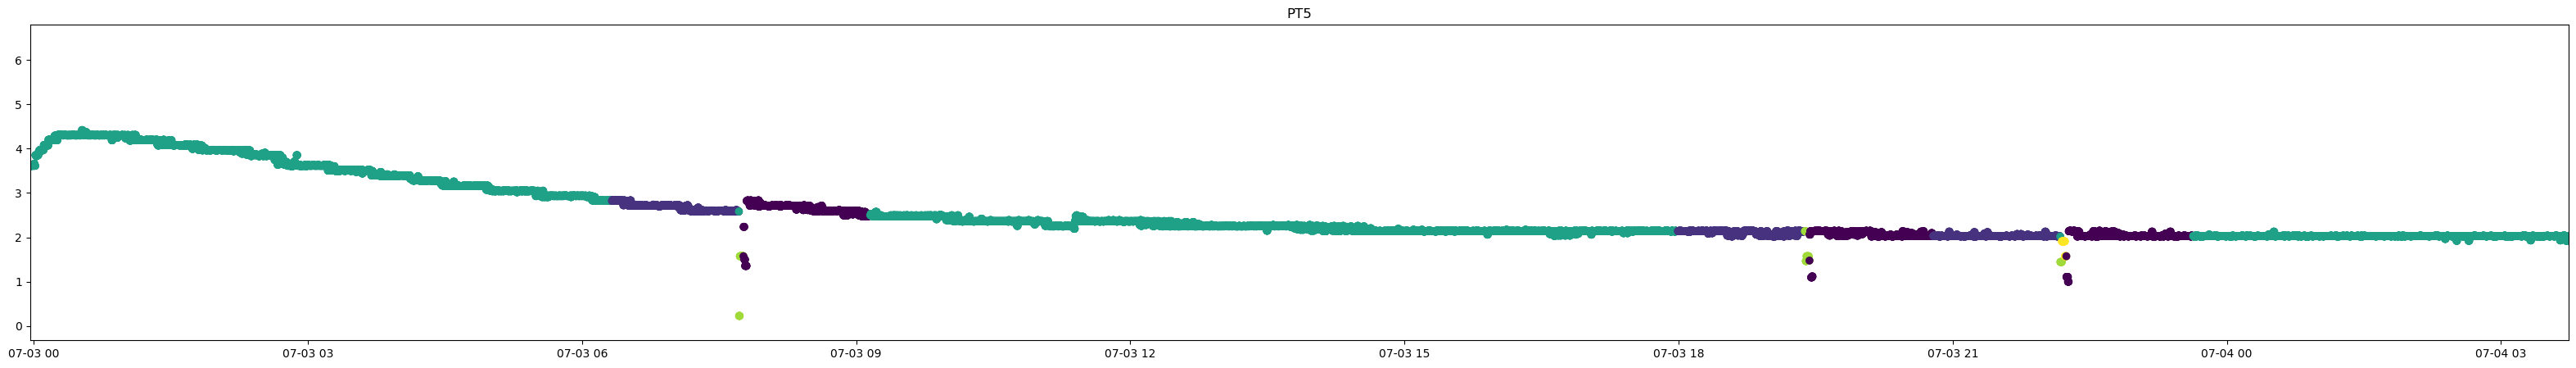

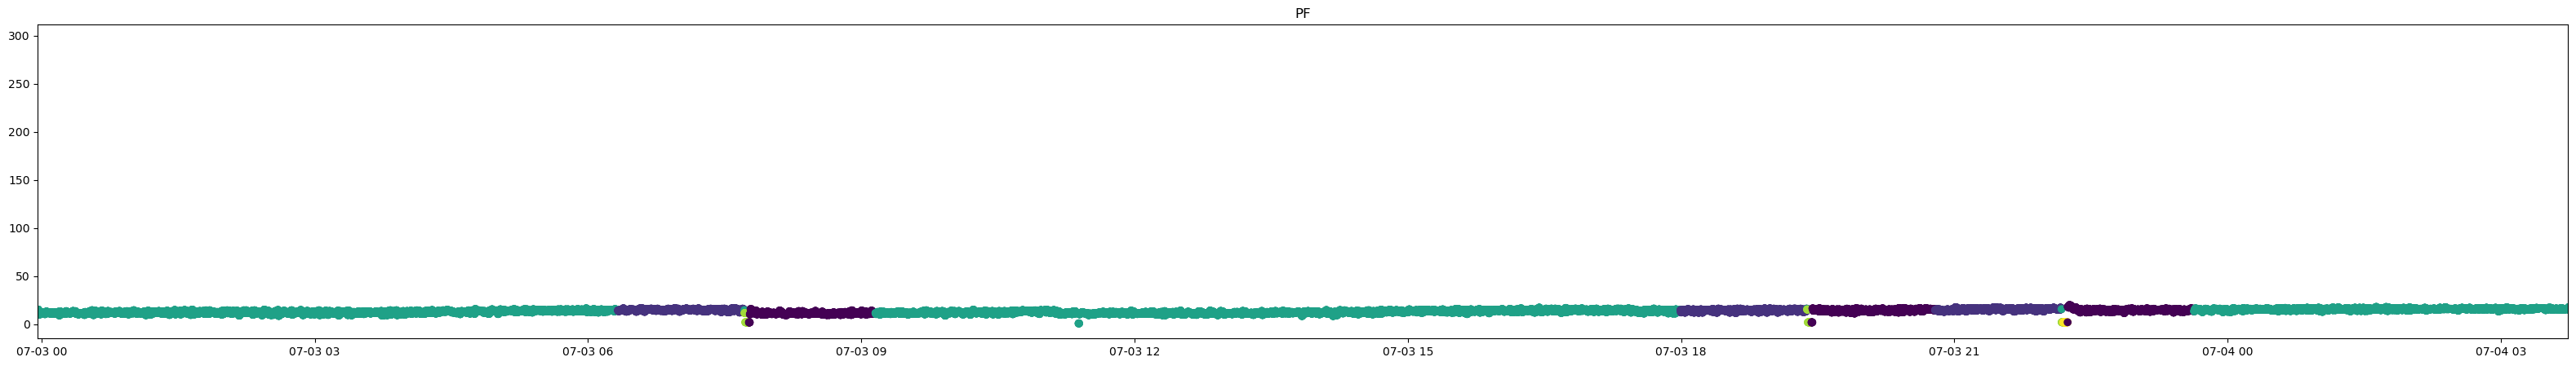

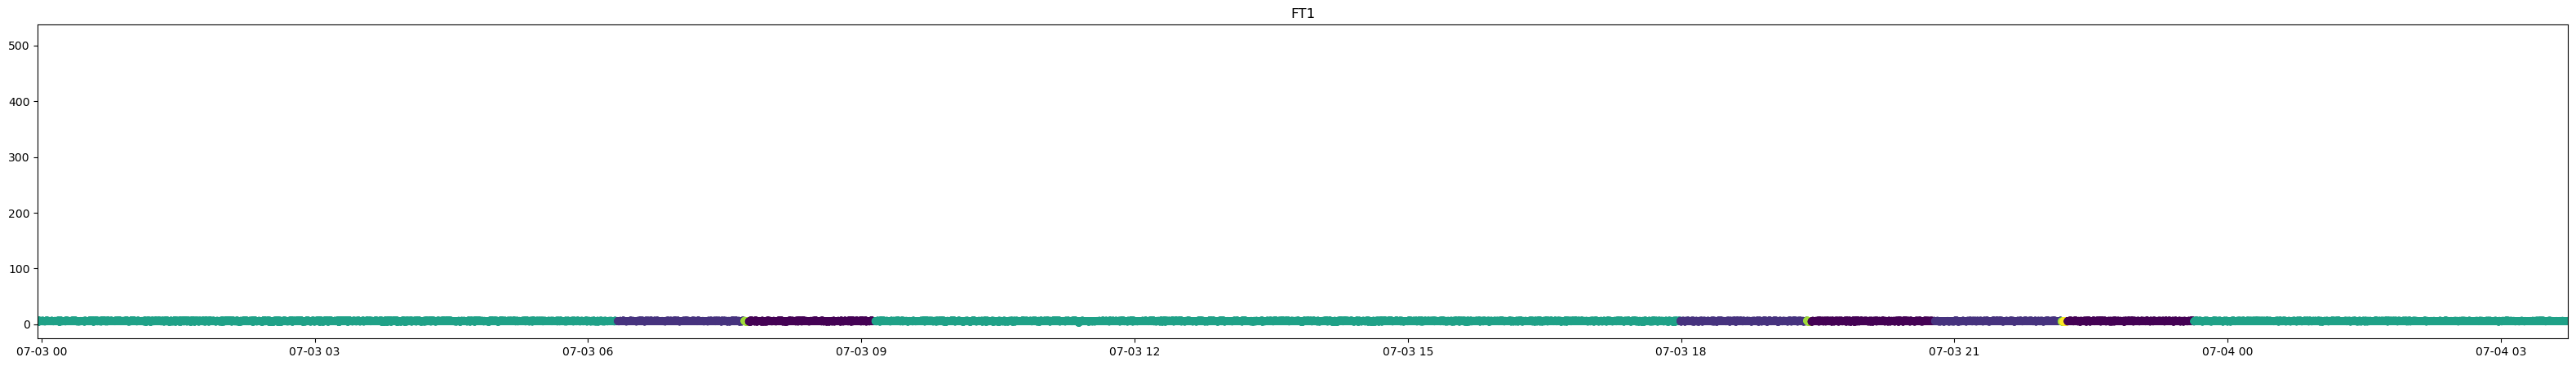

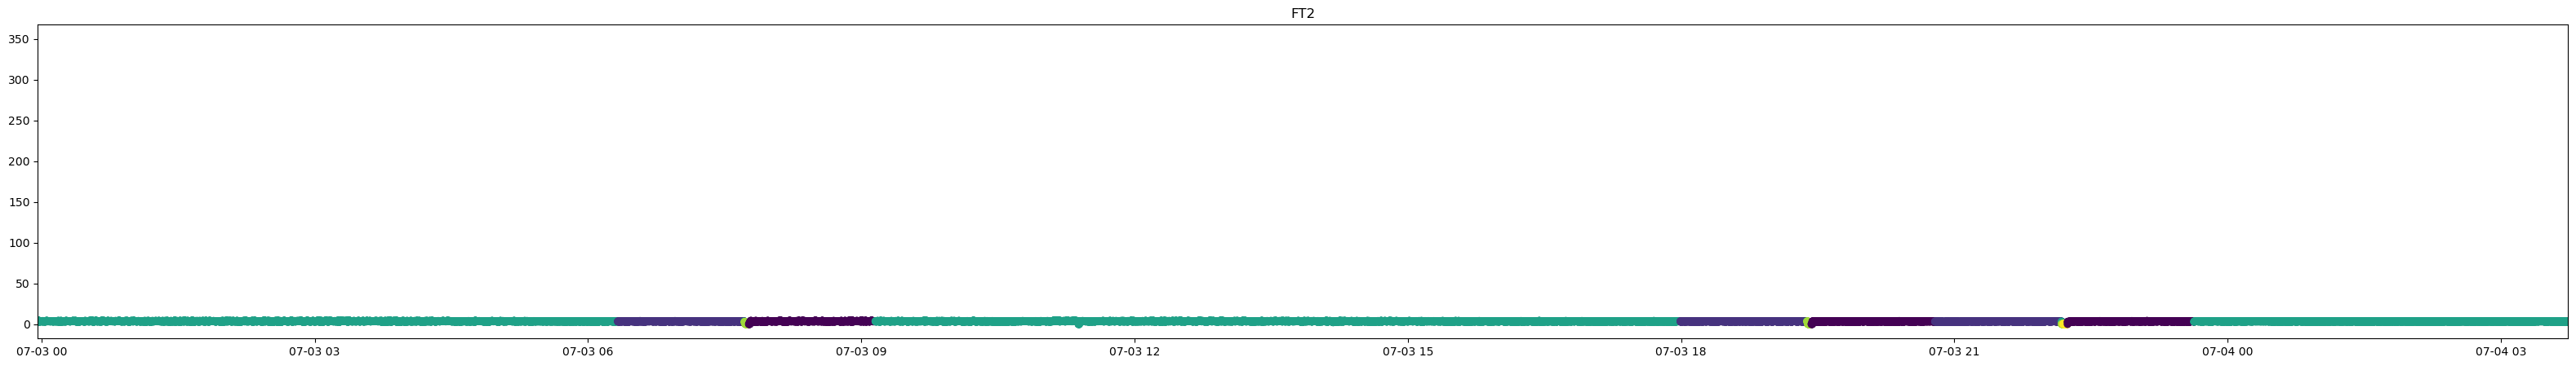

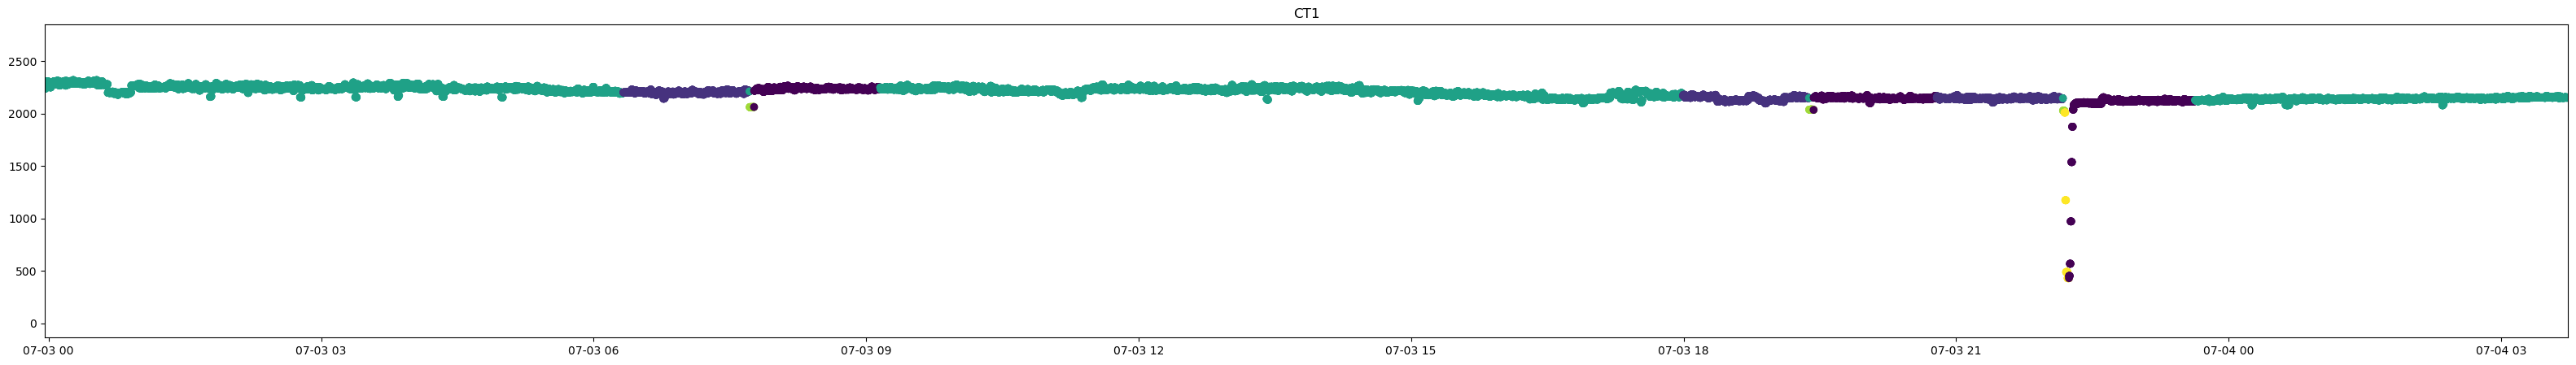

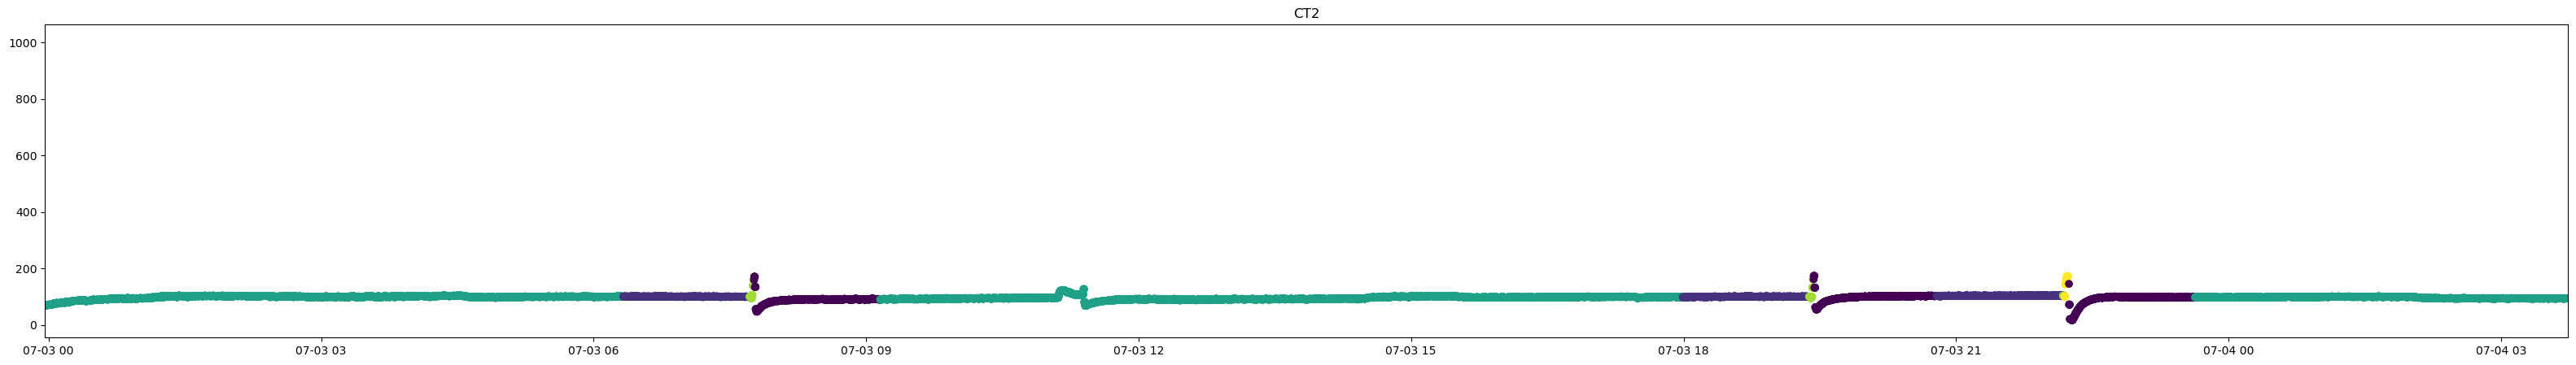

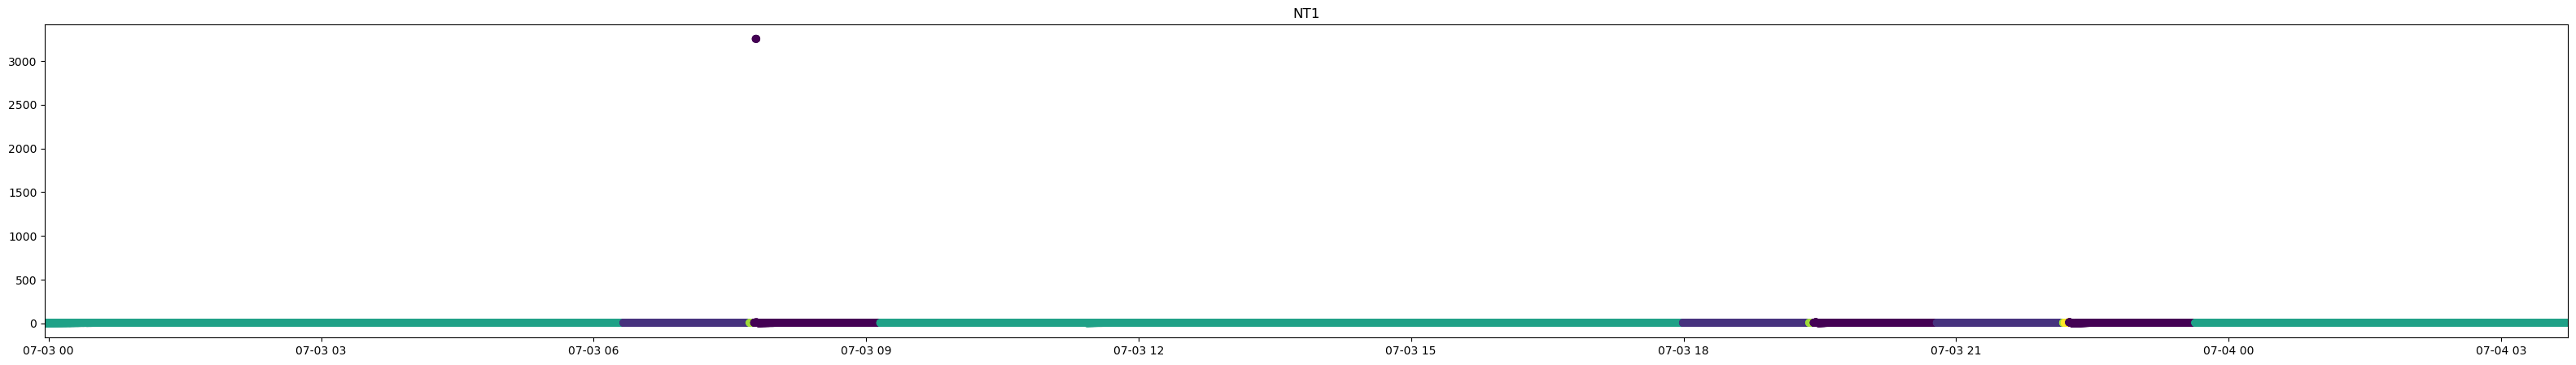

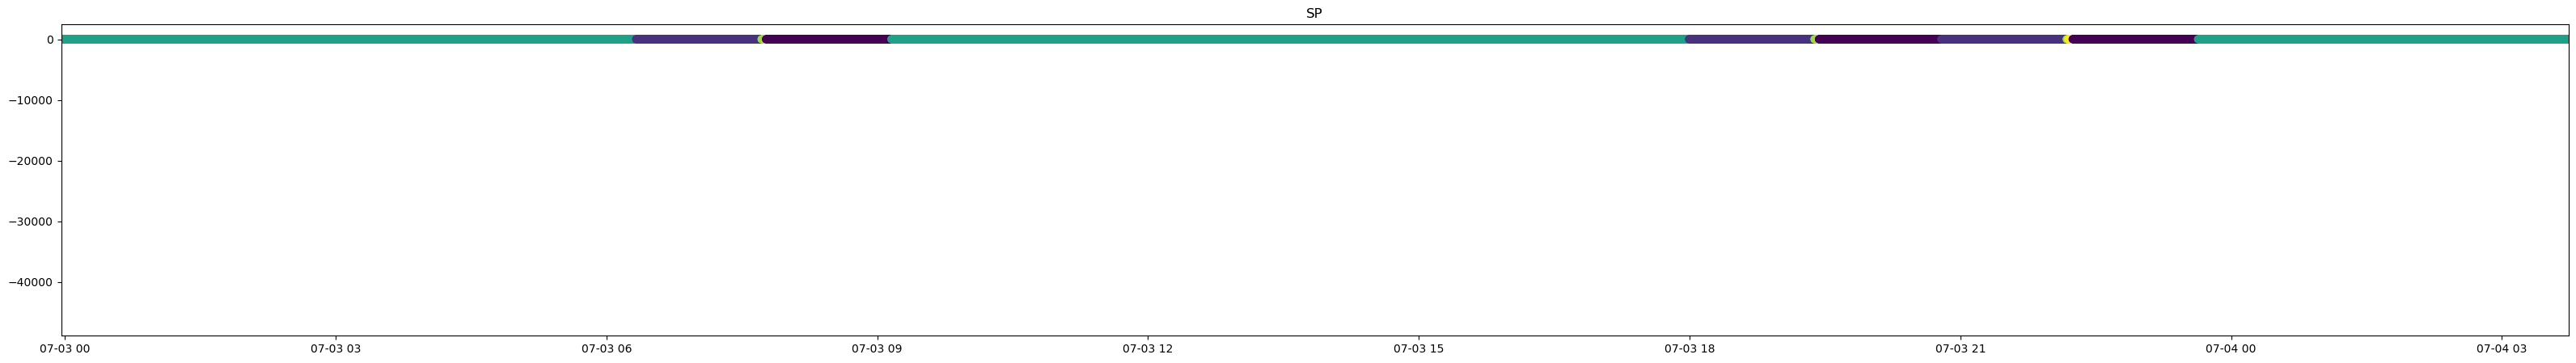

In [29]:
import matplotlib
%matplotlib inline 
from matplotlib import pyplot as plt
i, j = 0, len(df.index.values)
for col in features:
    
    if col == 'state':
        continue
    fig, ax =plt.subplots(figsize=(40,5))

    ax.scatter(df.index.values[i:j], df[col].values[i:j], c=df.state.values[i:j])
    plt.title(col)
    plt.xlim(left=df.index.values[0], right=df.index.values[20000])
    plt.show()

In [30]:
df.state.value_counts()

 3.0    2187514
 2.0    1794033
-2.0     421273
-1.0     419000
 5.0      95178
 4.0       4932
Name: state, dtype: int64

In [31]:
df.head()

,PT4,FT0,PT2,PT3,PT5,PF,FT1,FT2,CT1,CT2,NT1,SP,state
datetime,,,,,,,,,,,,,
2020-07-02 23:57:35,127.8031,2.439792,81.86849,134.856,3.602431,15.192457,7.065172,4.62538,2237.413,69.44445,3.354734,3.103783,2.0
2020-07-02 23:57:40,127.8031,2.439792,81.86849,134.856,3.602431,15.192457,7.065172,4.62538,2237.413,69.44445,3.354734,3.103783,2.0
2020-07-02 23:57:45,127.8031,2.439792,81.86849,134.856,3.602431,15.192457,7.065172,4.62538,2237.413,69.44445,3.354734,3.103783,2.0
2020-07-02 23:57:50,127.8031,2.439792,81.86849,134.856,3.602431,15.192457,7.065172,4.62538,2237.413,69.44445,3.354734,3.103783,2.0
2020-07-02 23:57:55,127.8031,2.439792,81.86849,134.856,3.602431,15.192457,7.065172,4.62538,2237.413,69.44445,3.354734,3.103783,2.0


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4921930 entries, 2020-07-02 23:57:35 to 2021-04-13 19:58:20
Freq: 5S
Data columns (total 13 columns):
 #   Column  Dtype  
---  ------  -----  
 0   PT4     float64
 1   FT0     float64
 2   PT2     float64
 3   PT3     float64
 4   PT5     float64
 5   PF      float64
 6   FT1     float64
 7   FT2     float64
 8   CT1     float64
 9   CT2     float64
 10  NT1     float64
 11  SP      float64
 12  state   float64
dtypes: float64(13)
memory usage: 525.7 MB


In [33]:
modified = True

if modified:
    if not os.path.exists('./bluerock_modified'):
        os.mkdir('./bluerock_modified')
        
    df['mean(PT3, PT4)'] = (df['PT3'] + df['PT4'])/2
    df = df.drop(['PT3', 'PT4'], axis=1)
    df.to_csv('./bluerock_modified/data.csv', index=True)
    
else:
    df.to_csv('./bluerock/data.csv', index=True)

In [34]:
def filter_data_by_state(data, state):
    data_filtered = data[data.state == state]
    data_filtered = data_filtered.drop('state', axis=1)
    if 'FN' in data_filtered.columns:
        data_filtered = data_filtered.drop('FN', axis=1)
    return data_filtered 

def create_dummy_attack_variables(data):
    attacks = np.zeros(data.shape[0])
    dummy_pos = np.random.choice(np.arange(0, data.shape[0], 1), int(data.shape[0]/2))
    attacks[dummy_pos] = np.ones_like(attacks[dummy_pos])
    data['attack'] = attacks
    return data 

def create_train_test_split(data):
    train_len = int(0.7 * data.shape[0])
    train_data = data.iloc[:train_len,:]
    test_data = data.iloc[train_len:,:]
    return train_data, test_data 


In [35]:
from sklearn.preprocessing import MinMaxScaler 

def scaler_fit_transform(train_data, test_data):
    scaler = MinMaxScaler()
    X_train = train_data.values 
    X_train = scaler.fit_transform(X_train)
    train_data_scaled = pd.DataFrame(X_train, columns=train_data.columns)
    X_test = test_data.iloc[:, :-1].values 
    X_test = scaler.transform(X_test)
    test_data_scaled = pd.DataFrame(X_test, columns=test_data.columns[:-1])
    test_data_scaled['attack'] = test_data['attack'].values
    return train_data_scaled, test_data_scaled, scaler 



In [36]:
rostates = [-2, -1, 2, 3, 4, 5]
if modified:
    out_dir = './bluerock_modified'
    for rostate in rostates:
        if not os.path.exists(f'./data/{rostate}_modified'):
            os.mkdir(f'./data/{rostate}_modified')
            
else:
    out_dir = './bluerock'
    for rostate in rostates:
        if not os.path.exists(f'./data/{rostate}'):
            os.mkdir(f'./data/{rostate}')
        

for rostate in rostates:
    if not os.path.exists(f'{out_dir}/{rostate}'):
        os.mkdir(f'{out_dir}/{rostate}')
    scaler_file = f'{out_dir}/{rostate}/scaler.sav'
    timestamps_file = f'{out_dir}/{rostate}/timestamps.sav'
    evaluation_timestamps_file = f'{out_dir}/{rostate}/eval_timestamps.sav'
    train_file = f'{out_dir}/{rostate}/train.csv'
    test_file = f'{out_dir}/{rostate}/test.csv'
    train_data, test_data = create_train_test_split(df)
    print(train_data.shape, test_data.shape)
    train_data = filter_data_by_state(train_data, rostate)
    test_data = filter_data_by_state(test_data, rostate)
    print('Filtering by State: ', rostate)
    print(train_data.shape, test_data.shape)
    with open(evaluation_timestamps_file, 'wb') as f:
        pickle.dump(test_data.index.values, f)
    test_data = create_dummy_attack_variables(test_data)
    test_data.to_csv(f'{out_dir}/{rostate}/test_orig.csv', index=True)
    train_data_scaled, test_data_scaled, scaler = scaler_fit_transform(train_data, test_data)
    with open(f'./{out_dir}/{rostate}/scaler.sav', 'wb') as f:
        pickle.dump(scaler, f)
    test_data_scaled.attack.value_counts()
    train_data_scaled.to_csv(train_file, index=False)
    test_data_scaled.to_csv(test_file, index=False)
    if modified:
        train_data_scaled.to_csv(f'./data/{rostate}_modified/train.csv', index=False)
        test_data_scaled.to_csv(f'./data/{rostate}_modified/test.csv', index=False)
    else:
        train_data_scaled.to_csv(f'./data/{rostate}/train.csv', index=False)
        test_data_scaled.to_csv(f'./data/{rostate}/test.csv', index=False)

(3445351, 12) (1476579, 12)
Filtering by State:  -2
(311585, 11) (109688, 11)
(3445351, 12) (1476579, 12)
Filtering by State:  -1
(310000, 11) (109000, 11)
(3445351, 12) (1476579, 12)
Filtering by State:  2
(1315440, 11) (478593, 11)
(3445351, 12) (1476579, 12)
Filtering by State:  3
(1420966, 11) (766548, 11)
(3445351, 12) (1476579, 12)
Filtering by State:  4
(3935, 11) (997, 11)
(3445351, 12) (1476579, 12)
Filtering by State:  5
(83425, 11) (11753, 11)
